## Logistic Regression


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [311]:
## 导入数据
from sklearn.datasets import load_iris
rawData = load_iris()
#a = np.delete(rawData['data'][:100],[2, 3], axis=1)
# 使用np.c_[]和np.r_[]分别添加行和列
raw_data = np.c_[rawData['data'][:100] ,rawData['target'][:100]]
raw_data = np.insert(raw_data, 0 ,[1 for i in range(len(raw_data))], 1)
shuffleData(raw_data)
data = raw_data[:5]
check_data = raw_data[5:]



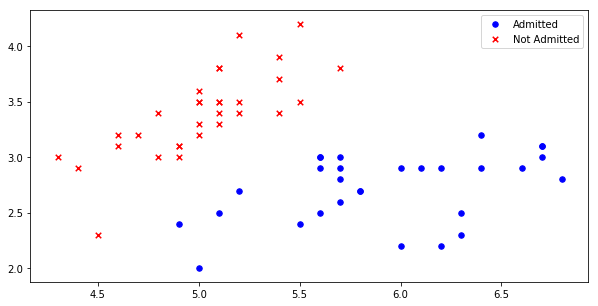

In [268]:
fig, ax = plt.subplots(figsize=(10,5))
positive=dict()
negative = dict()
positive['feat1'] = [i[1] for i in data if i[-1] == 1]
positive['feat2'] = [i[2] for i in data if i[-1] == 1]

negative['feat1'] = [i[1] for i in data if i[-1] == 0]
negative['feat2'] = [i[2] for i in data if i[-1] == 0]

ax.scatter(positive['feat1'],positive['feat2'], s=30, c='b', marker='o', label="Admitted")
ax.scatter(negative['feat1'], negative['feat2'], s=30, c='r', marker='x', label="Not Admitted")
ax.legend()

目标：建立分类器（求解三个参数$\theta_0,\theta_1,\theta_2$）<br>设定阈值，根据阈值判定结果
### 要完成的模块
* sigmoid 函数： 映射到概率的函数
* hypothesis: 返回预测结果值
* cost: 代价函数
* gradient: 计算每个参数的梯度
* descent: 更新参数


### sigmoid 函数
$$g(z)=\frac{1}{1+e^{-z}}$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


### Hypothesis:
$$h_\theta(x)=\frac{1}{1+e^{-\theta^Tx}}$$

In [99]:
def hypothesis(theta, x):
    ans = sigmoid(np.dot(x, theta.T))
   # print("len of ans of hypothesis", ans.shape)
    return ans

### 代价函数
---
代价函数：
$$Cost(h_\theta(x),y)= y^{(i)}\log h_\theta(x^{(i)})+(1-y^{(i)})\log(1-h_\theta(x^{(i)}))$$
求样本平均代价：
$$J(\theta) = -\frac{1}{m}\sum^{n}_{i=1}Cost(h_\theta(x^{(i)}),y^{(i)})$$

In [10]:
def cost(X, y, theta):
    cost = np.multiply(y, np.log(hypothesis(theta, X))) + np.multiply((1 - y),np.log(1 - hypothesis(theta, X)))
    return - np.sum(cost) / len(y)

In [63]:
cost(x,y,theta)

0.6931471805599453

### 计算梯度
---
$$\frac{\partial J}{\partial \theta_j} = -\frac{1}{m}\sum^{m}_{i=1}(y_i - h_\theta(x_i))x_{ij}$$

In [202]:
def gradient(x, y, theta):
    #print("len of y" , y.shape)
    grad = np.zeros(theta.shape) 
    delta = (hypothesis(theta, x) - y).ravel() #ravel() 将多维数组转为一维数组
    
    #print("len of delta of func_gradient:",(delta.shape))
    for i in range(len(theta.ravel())):
       # print(i, len(x) , x[:, i])
        term = np.multiply(delta, x[:, i]) #np.multiply():数组和矩阵对应位置相乘，输出与相乘数组/矩阵的大小一致
        grad[0, i] = np.sum(term) / len(x)
    return grad

### Gradient Descent
---
**共有三中不同的下降方法**
* 批量梯度下降： 容易得到最优解，但每次考虑所有样本，速度慢。
* 随机梯度下降： 每次找一个样本，迭代速度快，但不一定每次都朝着收敛方向
* 小批量梯度下降：每次更新选择的一小部分数据。 

In [21]:
STOP_ITER = 0 # 根据迭代次数停止
STOP_COST = 1 # 根据代价变化停止
STOP_GRAD = 2 # 根据梯度变换停止

def stopCondition(type, value, threshold): # threshold 阈值
    if type == STOP_ITER: return value > threshold
    elif type == STOP_COST: return abs(value[-1] - value[-2]) < threshold
    elif type == STOP_GRAD: return np.linalg.norm(value) < threshold #np.linalg.norm 求向量范数
    

In [127]:
# 时间测量函数
def timer(func):
    import time
    def wrapper(*args):
        start = time.time()
        a = func(*args)
        end = time.time()
        print("总用时为：{}s".format(round(end - start, 2)))
        return a
    return wrapper

def shuffleData(data):
    # 洗牌数据
    np.random.shuffle(data)
    cols = data.shape[1]
    x = data[:, 0: cols - 1]
    y = data[:, cols -1:]
    return x,y

In [156]:
@timer
def descent(data, theta, sampleSize, stopType, threshold, alpha):
    # sampleSize: 以样本大小判断梯度下降方法
    # stopType: 迭代停止条件类型
    # threshold： 停止条件阈值
    # alpha：学习率
    iterator = 0 # 迭代次数
    k = 0 # 样本大小
    x, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 初始梯度
    costs = [cost(x, y, theta)] # 每次迭代的代价值
    
    
    while True:
        if k + sampleSize > len(x):
            k = 0
            x, y = shuffleData(data)
        grad = gradient(x[k: k + sampleSize], y[k: k + sampleSize], theta)
        k += sampleSize
        theta = theta - alpha * grad #更新参数
        costs.append(cost(x, y, theta)) # 重新计算代价
        iterator += 1
        #print("current iterator:",iterator)
        # 停止条件
        if stopType == STOP_ITER:  value = iterator
        elif stopType == STOP_COST:  value = costs
        elif stopType == STOP_GRAD:  value = grad
        if stopCondition(stopType, value, threshold):  break
            
    return theta, costs, iterator
        
    
    

In [210]:
def run(data, theta, sampleSize, stopType, threshold, alpha):
    
    theta, costs, iterator = descent(data, theta, sampleSize, stopType, threshold, alpha)
    print("theta: {}\ncost: {}  iteration: {}".format(theta, round(costs[-1], 4), iterator))
    name = "learning rate: {} - ".format(alpha)
    if sampleSize == len(x):  descType = "Gradient"
    elif sampleSize == 1:  descType = "Stochastic"
    else:  descType = "Mini-batch({}) - ".format(sampleSize)
    name += descType + "- Stop Condition: "
    if stopType == STOP_ITER:  strStop = "{} iterations".format(threshold)
    elif stopType == STOP_COST: strStop = "cost change < {}".format(threshold)
    else:  strStop = "gradient norm < {}".format(threshold)
    name += strStop
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Cost")
    ax.set_title(name)
    return theta

### 对比不同的梯度下降方法
---
#### Stochastic Descent

总用时为：0.0s
theta: [[-0.02083635 -0.05267293 -0.1072699   0.09949953  0.0424373 ]]
cost: 0.59  iteration: 21


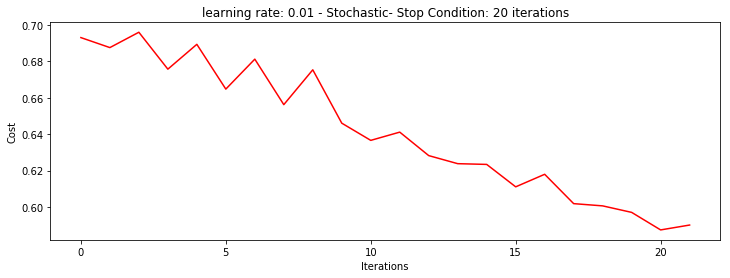

In [322]:
theta = np.zeros([1,5])
theta = run(data, theta, 1, STOP_ITER, threshold= 20, alpha= 0.01)

**减小学习率，可以增加稳定性，但cost变大了**

总用时为：0.01s
theta: [[-0.01230803 -0.02443412 -0.06675015  0.07545313  0.03096412]]
cost: 0.6152  iteration: 151


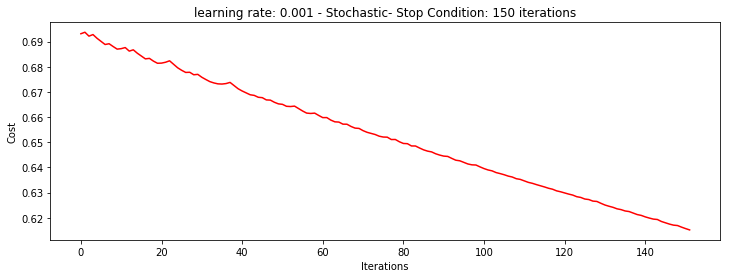

In [318]:
theta = np.zeros([1,5])
theta = run(data, theta, 5, STOP_ITER, threshold= 150, alpha= 0.001)

#### Mini-batch descent

总用时为：0.83s
theta: [[-0.58333529 -0.75967366 -3.12955061  4.4112344   1.91928503]]
cost: 0.0003  iteration: 10001


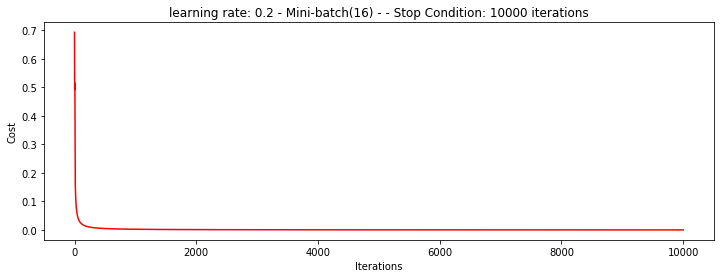

In [319]:
theta = np.zeros([1,5])
theta = run(data, theta, 16 , STOP_ITER, threshold= 10000, alpha= 0.2)

### 精度
---

In [282]:
def predict(X, theta):
    #print(hypothesis(theta=theta, x=X))
    return [1 if x >= 0.5 else 0 for x in hypothesis(theta=theta, x=X)]

In [323]:
x = check_data[:,0:len(check_data[0]) - 1]
#print(check_data.shape)
y = check_data[:,-1]
results = predict(x,theta)
ans = 0.0
for i in range(len(x)):
    if y[i] == results[i]:
        ans += 1
print('accuracy = {}%'.format(round((ans / len(x)) * 100, 2)))
        

accuracy = 49.47%
